In [173]:
'''
Goal: Predict doge coin value for the next day

Method: Give the model data of the doge coin values for the last 30 days (about a month) and
have it predict the next value

References:
https://www.kaggle.com/dhruvildave/dogecoin-historical-data
https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array
https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
'''

import pandas as pd
import numpy as np

SPLIT = 0.8 # Train test split
PAST_DAYS = 30 # Number of days the model can look at in the past

file_data = pd.read_csv('./DOGE-USD.csv', sep=',')
doge_val = file_data['Close'] # Extract only end values
doge_val = [x for x in doge_val if x] # Get rid of null values (Hacky method considering lost days)

# Get rid of nan values
doge_val = np.array(doge_val)
doge_val = doge_val[~np.isnan(doge_val)]

# Split training and test sets
split_ind = int(len(doge_val) * SPLIT)

# All possible 30 consecutive days (about a month), disjoint train and test data
train_data = [[doge_val[x + y] for y in range(PAST_DAYS + 1)] for x in range(split_ind - PAST_DAYS)]
test_data = [[doge_val[x + y] for y in range(PAST_DAYS)] for x in range(split_ind, len(doge_val) - PAST_DAYS + 1)]

# Columns for pandas dataframe, but only inputs
cols_x = ['d{}'.format(x + 1) for x in range(PAST_DAYS)]

# Input for model training/testing
train_input = pd.DataFrame(data = train_data, columns = cols_x + ['y'])
test_input = pd.DataFrame(data = test_data, columns = cols_x)

In [174]:
from sklearn import linear_model

# Training
model = linear_model.LinearRegression()
model.fit(train_input[cols_x], train_input['y'])

# Line below is the same as the one from LinearRegression notebook
print('Intercept: {i}  Coefficients: {c}'.format(i=model.intercept_, c=model.coef_))

Intercept: 1.2729535066441844e-05  Coefficients: [ 1.21532470e-01 -1.06924312e-01 -7.12095183e-04  4.77133102e-02
 -5.79648352e-02  7.00354404e-02 -2.29974476e-02 -1.07907308e-01
  2.24834575e-02 -6.77884047e-02  1.47364282e-01  4.81409998e-02
 -2.53949007e-01  1.89765047e-01 -3.71416271e-02  3.33440231e-02
 -6.62211690e-02 -9.70434879e-02  1.15004186e-01  1.14923722e-01
  1.77811612e-02 -8.49293486e-02 -1.09854191e-01  4.47897307e-02
 -7.59953359e-02  2.44254413e-01 -1.49486129e-01  7.46745229e-03
 -1.31317309e-01  1.13889883e+00]


Mean Squared Error: 7.035318164012714e-05


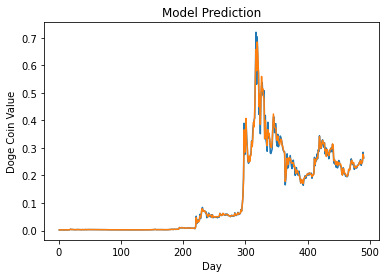

In [175]:
# Mean squared error
from sklearn.metrics import mean_squared_error

y_pred = model.predict(test_input)
y_true = doge_val[split_ind + PAST_DAYS - 1:]

print("Mean Squared Error: {}".format(mean_squared_error(y_true, y_pred)))

# Graph the prediction line against the actual values
import matplotlib.pyplot as plt

x = [i + 1 for i in range(len(test_input))]

plt.plot(x, y_pred)
plt.plot(x, y_true)

plt.xlabel('Day')
plt.ylabel('Doge Coin Value')
plt.title('Model Prediction')

plt.show()

The model looks like a success, but we should look more closely.

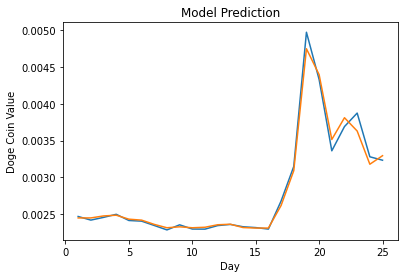

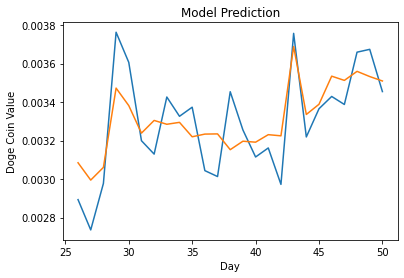

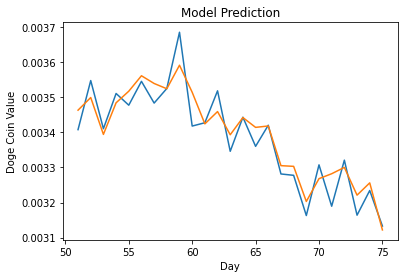

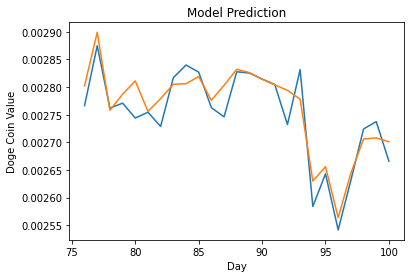

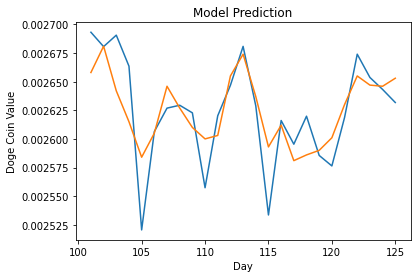

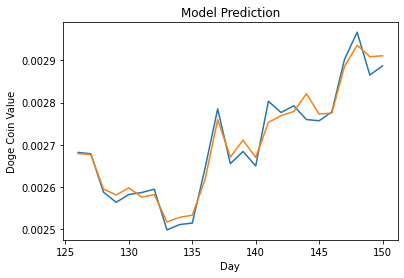

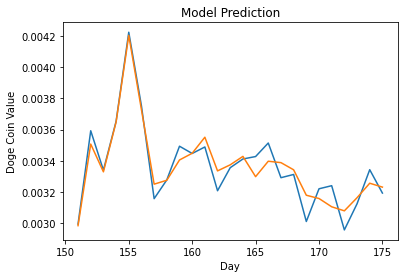

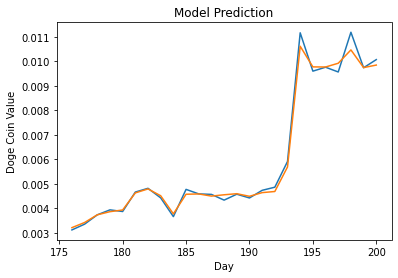

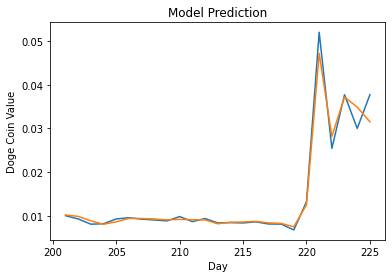

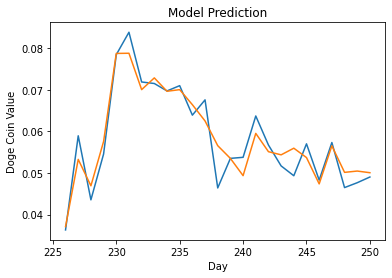

In [176]:
# Graph the prediction line against the actual values, but only a small portion
import matplotlib.pyplot as plt

TEST_SIZE = 25
BATCHES = 10

if (TEST_SIZE * BATCHES <= len(test_data)):
    for plot_num in range(BATCHES):
        x = [i + 1 for i in range(TEST_SIZE * plot_num, TEST_SIZE * (plot_num + 1))]

        plt.plot(x, y_pred[TEST_SIZE * plot_num : TEST_SIZE * (plot_num + 1)])
        plt.plot(x, y_true[TEST_SIZE * plot_num : TEST_SIZE * (plot_num + 1)])

        plt.xlabel('Day')
        plt.ylabel('Doge Coin Value')
        plt.title('Model Prediction')

        plt.show()
else:
    print("TEST_SIZE ({}) x BATCHES ({}) exceeds limit ({})".format(TEST_SIZE, BATCHES, len(test_data)))

The values seem off at times, but whether it goes up or down seems to be fairly accurate. For a simpler way to tell, I decided to have a simple accuracy check on whether it rises or falls.

In [177]:
correct = 0
for i in range(len(test_data) - 1):
    if not ((y_pred[i + 1] > y_pred[i]) ^ (y_true[i + 1] > y_true[i])):
        correct += 1

print(correct / (len(test_data) - 1))

0.7934560327198364


It seems to be actually predicting it fairly well. We can look further into it by separating it using a confusion matrix.

In [178]:
# Positive - rise in value : Negative - fall in value
conf_mat = np.zeros((2, 2))
for i in range(len(test_data) - 1):
    conf_mat[int(y_true[i + 1] < y_true[i])][int(y_pred[i + 1] < y_pred[i])] += 1

print(conf_mat)

[[197.  50.]
 [ 53. 189.]]


I'm surprised to see that it's predicting fairly well. I had background knowledge on stocks and how it was still a problem that was far from being solved with AI, but maybe Doge coins happened to just be easier to predict. I initially hypothesized that the model would just look at the past two days, ignoring all the other values, to see if the value went up or down and follow that general direction, but it seems that that's not the case. I'm not sure whether to believe that the training went well or if it was just a coincidence since most people using advanced AI on stocks were not having much success. It could also have been the possibility that cryptocurrencies aren't affected as much by external factors as much as stocks are since stocks are often affected by whatever news there is about the company while cryptocurrencies are mostly dependent on the current graph of its value, but this doesn't mean that external factors can't come into play. For example, if stocks aren't doing well for whatever reason, people might take money out of stocks and put it into crypto. I think this is an interesting project to look further into in the future.